In [ ]:
# =========================
# Time Series Forecasting: Random Forest vs Transformer (GPU optional)
# export PATH="/c/Users/Pedro/AppData/Local/Programs/Python/Python311:$PATH"
# =========================


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# -------------------------
# 1) Load & preprocess data
# -------------------------
df = pd.read_csv('PJME_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

# Random Forest lag & rolling features
df['lag1'] = df['PJME_MW'].shift(1).fillna(method='bfill')
df['roll_mean_3'] = df['PJME_MW'].rolling(window=3, min_periods=1).mean()
df = df.dropna(subset=['lag1','roll_mean_3'])

features_rf = ['lag1', 'roll_mean_3']
target = 'PJME_MW'

X_rf = df[features_rf].values
y = df[target].values

# Train/test split
split_idx = int(len(X_rf)*0.8)
X_train_rf, X_test_rf = X_rf[:split_idx], X_rf[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features for Transformer
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rf)
X_test_scaled = scaler.transform(X_test_rf)

In [10]:
import torch
import gc
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


torch.cuda.empty_cache()  # free gpu/cached memory
gc.collect()
torch.cuda.empty_cache()

True
NVIDIA GeForce RTX 3060


In [1]:
# -------------------------
# 2) Random Forest Model
# -------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train)
y_pred_rf = rf_model.predict(X_test_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE:", mse_rf)

# -------------------------
# 3) Transformer Model (GPU-friendly, batch training)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Use DataLoader for mini-batches
batch_size = 256
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Transformer definition
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=2, num_heads=2, num_layers=1, hidden_dim=32, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(feature_size, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)  # add sequence dimension
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch, features)
        x = self.transformer(x)
        x = x[-1, :, :]
        x = self.fc_out(x)
        return x

model = TimeSeriesTransformer(feature_size=X_train_t.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with mini-batches (this is to help out with gpu memory allocation - my gpu is limited to 12gb)
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")

# Evaluation
model.eval()
y_pred_trans_list = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        y_pred_batch = model(batch_X)
        y_pred_trans_list.append(y_pred_batch.cpu())
y_pred_trans = torch.cat(y_pred_trans_list).numpy()

mse_trans = mean_squared_error(y_test, y_pred_trans)
print("Transformer MSE:", mse_trans)


NameError: name 'RandomForestRegressor' is not defined

# Assistant
The error message indicates that you're trying to use `RandomForestRegressor` somewhere in your code, but it hasn't been imported. This class is part of the scikit-learn library.

The error message doesn't match the code snippet you provided, as `RandomForestRegressor` isn't mentioned in the code you shared. However, it seems that somewhere in your notebook, you're trying to use this class without importing it first.

Would you like me to provide the corrected import statement?

# User
yes

In [2]:
# Assistant
# Add this import at the beginning of your notebook
from sklearn.ensemble import RandomForestRegressor

# The rest of your code remains the same

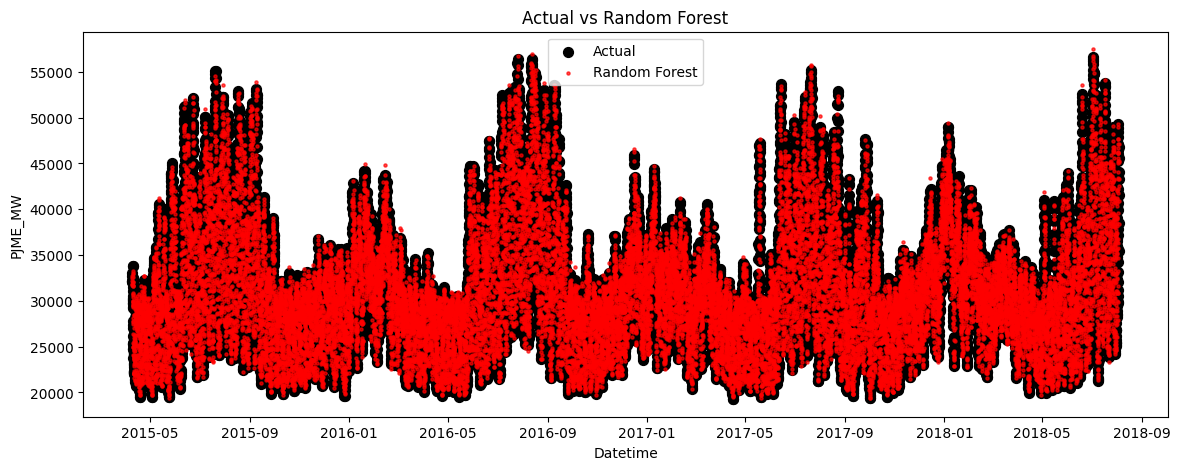

In [12]:
# -------------------------
# 4) Visualization (3 separate plots)
# -------------------------
dates_test = df['Datetime'][split_idx:]

# Actual vs Random Forest
plt.figure(figsize=(14,5))
plt.scatter(dates_test, y_test, label='Actual', color='black', s=50)      # big circles
plt.scatter(dates_test, y_pred_rf, label='Random Forest', color='red', s=5, alpha=0.7)  # small circles
plt.legend()
plt.title('Actual vs Random Forest')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.show()


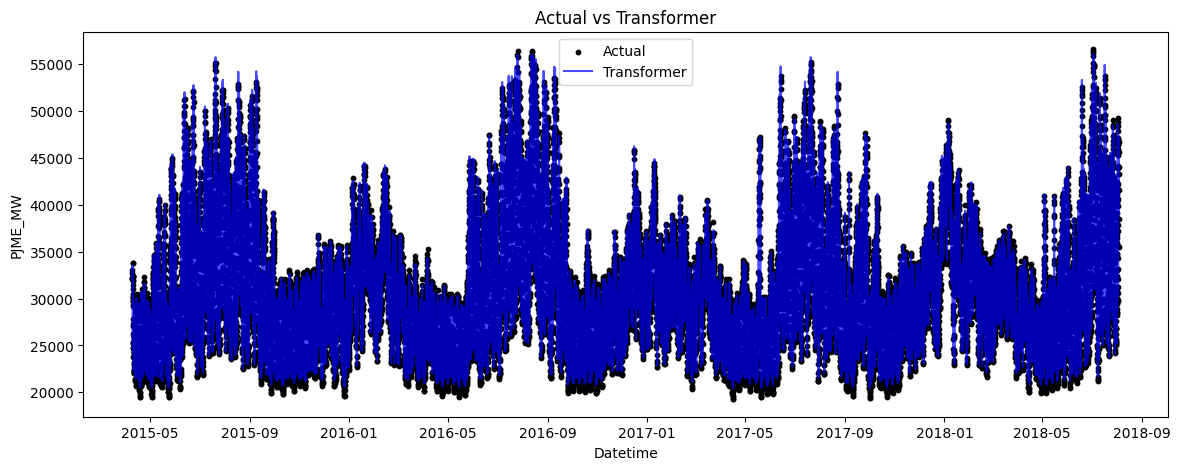

In [13]:
# Actual vs Transformer
plt.figure(figsize=(14,5))
plt.scatter(dates_test, y_test, label='Actual', color='black', s=10)  # bigger dots
plt.plot(dates_test, y_pred_trans, label='Transformer', color='blue', alpha=0.7)
plt.legend()
plt.title('Actual vs Transformer')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.show()

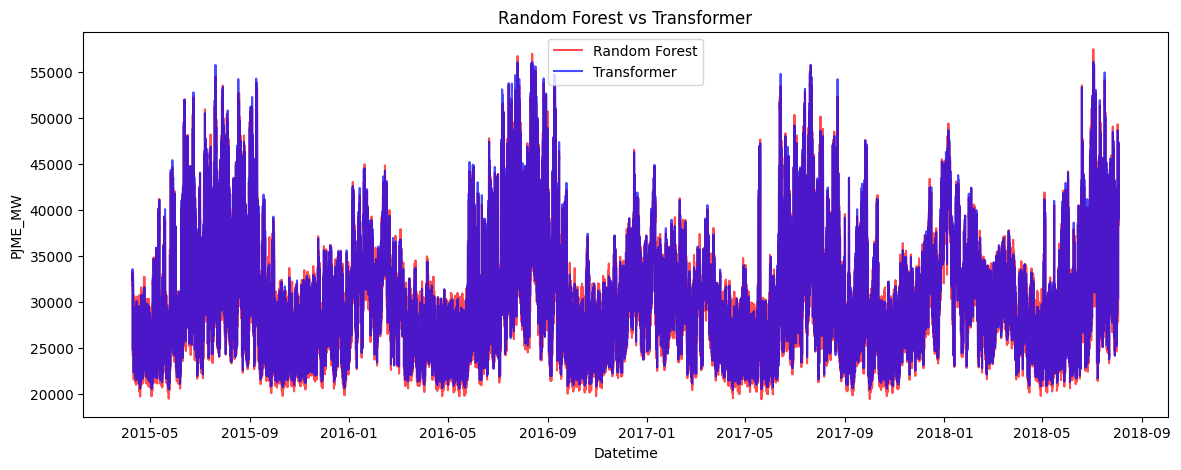

In [14]:
# Random Forest vs Transformer
plt.figure(figsize=(14,5))
plt.plot(dates_test, y_pred_rf, label='Random Forest', color='red', alpha=0.7)
plt.plot(dates_test, y_pred_trans, label='Transformer', color='blue', alpha=0.7)
plt.legend()
plt.title('Random Forest vs Transformer')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.show()

In [ ]:
# Data analytics forecast

import numpy as np
import pulp

# -------------------------
# 1) Generate random "forecast" (demand targets) for next 12 hours
# -------------------------
np.random.seed()  # remove fixed seed so each run differs
future_forecast = np.random.uniform(50, 200, size=12)  # random demand 50–200 MW

# -------------------------
# 2) LP Problem – Energy Scheduling
# -------------------------
prob = pulp.LpProblem("Energy_Optimization", pulp.LpMinimize)

# Decision variables: 3 generators
gens = ["Gen1", "Gen2", "Gen3"]
x = pulp.LpVariable.dicts("Gen", gens, lowBound=0)

# Costs per generator
costs = {"Gen1": 50, "Gen2": 70, "Gen3": 100}

# Objective: minimise total generation cost
prob += pulp.lpSum([costs[g]*x[g] for g in gens])

# Constraints: meet forecasted demand for each hour
for hour, demand in enumerate(future_forecast, 1):
    prob += pulp.lpSum([x[g] for g in gens]) >= demand, f"Demand_Hour_{hour}"

# Generator capacity constraints
max_capacity = {"Gen1": 100, "Gen2": 150, "Gen3": 80}
for g in gens:
    prob += x[g] <= max_capacity[g], f"Cap_{g}"

# Solve LP
prob.solve()

print("\nRandom demand forecast (MW):", np.round(future_forecast, 1))
print("\nOptimal Generator Schedule (LP):")
for g in gens:
    print(f"{g}: {x[g].varValue:.2f} MW")

# -------------------------
# 3) Simple SP: multiple scenarios (simulate demand uncertainty)
# -------------------------
scenarios = [future_forecast + np.random.normal(0, 10, size=len(future_forecast))
             for _ in range(3)]
expected_costs = []

for idx, s in enumerate(scenarios, 1):
    prob_sp = pulp.LpProblem(f"Energy_SP_Scenario_{idx}", pulp.LpMinimize)
    x_sp = pulp.LpVariable.dicts("Gen", gens, lowBound=0)
    prob_sp += pulp.lpSum([costs[g]*x_sp[g] for g in gens])
    for hour, demand in enumerate(s, 1):
        prob_sp += pulp.lpSum([x_sp[g] for g in gens]) >= demand, f"Demand_Hour_{hour}"
    for g in gens:
        prob_sp += x_sp[g] <= max_capacity[g], f"Cap_{g}"
    prob_sp.solve()
    cost = sum(costs[g] * x_sp[g].varValue for g in gens)
    expected_costs.append(cost)

print("\nExpected costs across 3 SP scenarios:", np.round(expected_costs, 2))



Random demand forecast (MW): [ 73.4 159.  142.   60.4 182.1 104.4  64.  140.2 174.  154.2 119.1 148.5]

Optimal Generator Schedule (LP):
Gen1: 100.00 MW
Gen2: 82.09 MW
Gen3: 0.00 MW

Expected costs across 3 SP scenarios: [10656.26 10980.24 10926.47]
